# Init

# Output possible d'une segmentation RFM

Une segmentaton RFM permet de créer des segments de clientèle exploitables et faciles à comprendre. Ci-dessous la liste des possibilités 

## Modules

In [35]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
import plotly.offline as pyoff
import plotly.graph_objs as go

from lifetimes.utils import summary_data_from_transaction_data

## Constantes

## Fonctions

In [36]:
def RFMScore(x,p,d):
    """
    A function for pareto analyis
    
    Arguments:
    d- dataframe with rfm information
    x- a number (float)
    pq -quantitative columns
        
    Returns:
      an integeer betwen 1 and 4
   """
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Chargement des données

In [37]:
sales = pd.read_pickle('intermed/sales.sav')

# RFM Analysis

In [38]:
# non null customer id
sales  = sales [~sales ['customer_Id'].isna()]
# Remove negattive quantities and sales
sales  = sales[sales ['Qty']>=0]
sales  = sales[sales ['total_amt']>=0]

In [39]:
 # date ware not parse as well. SOMETIMES with / or -
sales ['tran_date']=sales ['tran_date'].str.replace('/','-',)
sales ['transaction_date']=pd.to_datetime(sales ['tran_date'], format='%d-%m-%Y')
sales ['DOB']=pd.to_datetime(sales ['DOB'], format='%d-%m-%Y')

In [40]:
sales=sales.groupby(['transaction_id', 'transaction_date']).sum().reset_index()
sales.head()

,transaction_id,transaction_date,customer_Id,city_code,prod_cat_code,prod_sub_cat_code,prod_subcat_code,Qty,Rate,Tax,total_amt
0,3268991,2011-08-02,272172,10.0,6,11,11,3,91,28.665,301.665
1,7073244,2013-05-11,269640,7.0,5,12,12,4,1385,581.700,6121.700
2,10861359,2013-10-25,272671,7.0,4,4,4,2,103,21.630,227.630
3,15741026,2011-03-28,271544,5.0,5,12,12,1,299,31.395,330.395
4,16165359,2013-08-01,273203,2.0,1,4,4,2,580,121.800,1281.800


## Étape 1 Calcul des valeurs RFM

In [41]:
# Ceeate the rfm summary table from litetimes utility function
rfm = summary_data_from_transaction_data(sales, 'customer_Id', 'transaction_date', monetary_value_col='total_amt').reset_index()

*Récence* : L'âge du client lors de la dernière transaction. Ceci est légèrement différent du RFM vanille où la récence est calculée comme le nombre de jours depuis le dernier achat.

*Fréquence* : Le nombre d'achats au cours de la durée de vie du client

*Valeur monétaire* : la valeur monétaire moyenne des transactions des clients.

*T* : age du clients (pas top important ici)

<AxesSubplot:>

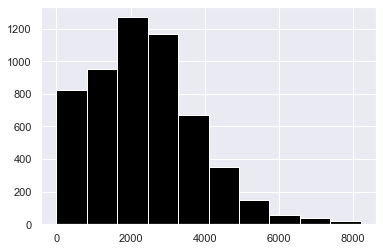

In [42]:
rfm.monetary_value.hist(color="black")

<AxesSubplot:>

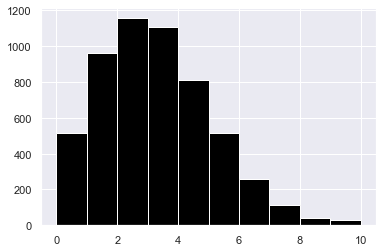

In [43]:
rfm.frequency.hist(color="black")

<AxesSubplot:>

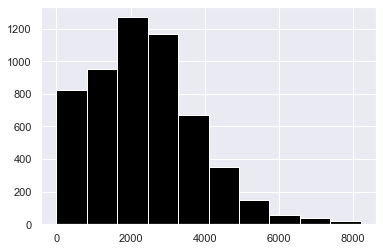

In [44]:
rfm.monetary_value.hist(color="black")

## Etapes  2  Discretisation des scores rfm

In [45]:
# Create the quartiles scores
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
    
quantiles

{'customer_Id': {0.25: 268908.25, 0.5: 271024.5, 0.75: 273171.75},
 'frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 4.0},
 'recency': {0.25: 338.0, 0.5: 622.0, 0.75: 830.0},
 'T': {0.25: 719.0, 0.5: 915.0, 0.75: 1036.75},
 'monetary_value': {0.25: 1347.1331249999998,
  0.5: 2290.665,
  0.75: 3219.8594999999996}}

In [46]:
rfm['R'] = rfm['recency'].apply(RFMScore, args=('recency',quantiles,))
rfm['F'] = rfm['frequency'].apply(RFMScore, args=('frequency',quantiles,))
rfm['M'] = rfm['monetary_value'].apply(RFMScore, args=('monetary_value',quantiles,))
rfm.head()

,customer_Id,frequency,recency,T,monetary_value,R,F,M
0,266783,3.0,516.0,881.0,1037.963333,2,2,1
1,266784,2.0,103.0,546.0,707.200000,1,2,1
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4
3,266788,3.0,611.0,984.0,1574.993333,2,2,2
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3


## Noms generiques des segments

Ici, nous concaténons  le score RFM individuel comme des chaînes et obtenons des segments étiquetés en retour.

Notre meilleur segment sera 444 et notre pire sera 111 - ce qui signifie le score le plus bas dans les trois catégories RFM.

In [64]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
rfm.head()

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,221,5,Hibernating,Green
1,266784,2.0,103.0,546.0,707.200000,1,2,1,121,4,Hibernating,Green
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,444,12,Champions,Platinum
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,222,6,Hibernating,Bronze
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,443,11,Champions,Platinum


## Friendly segments

Ici, nous additionnons les scores RFM individuels comme des nombres et obtenons en retour un nombre indiquant le score du client. 

Le score ira de 3 à 12 et nous pouvons l'utiliser pour créer des catégories étiquetées plus conviviales.

In [63]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,2.02.01.0,5,Hibernating,Green
1,266784,2.0,103.0,546.0,707.200000,1,2,1,1.02.01.0,4,Hibernating,Green
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,4.04.04.0,12,Champions,Platinum
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,2.02.02.0,6,Hibernating,Bronze
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,4.04.03.0,11,Champions,Platinum


In [49]:
# Create human friendly RFM labels
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][2-3]': 'At risk',
    r'[1-2]4': 'Can\'t loose them',
    r'2[1-2]': 'About to sleep',
    r'22': 'Need attention',
    r'[2-3][3-4]': 'Loyal customers',
    r'31': 'Promising',
    r'41': 'New customers',
    r'[3-4][1-2]': 'Potential loyalists',
    r'4[3-4]': 'Champions'
}

In [50]:
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

<AxesSubplot:xlabel='Segment', ylabel='count'>

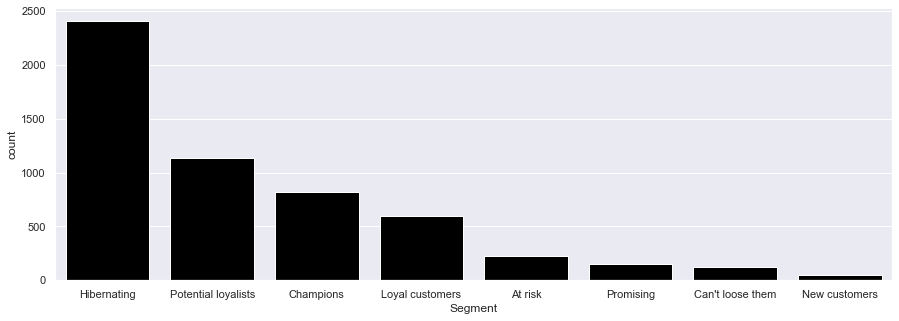

In [51]:
plt.figure(figsize=(15,5))
sns.countplot(data = rfm,     x = 'Segment', order = rfm['Segment'].value_counts().index,color = "black")

Malheureusement, il semble que la plupart de nos clients hibernent, alors nous ferions mieux d'y aller. 

Du bon côté : Nous avons quelques champions, et aussi quelques clients dans les catégories clients fidèles . 

Nous ferions mieux de bien nous occuper d'eux.

In [66]:
# Create some human friendly labels for the scores
rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
rfm.head()

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,221,5,Hibernating,Green
1,266784,2.0,103.0,546.0,707.200000,1,2,1,121,4,Hibernating,Green
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,444,12,Champions,Platinum
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,222,6,Hibernating,Bronze
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,443,11,Champions,Platinum


<AxesSubplot:xlabel='Score', ylabel='count'>

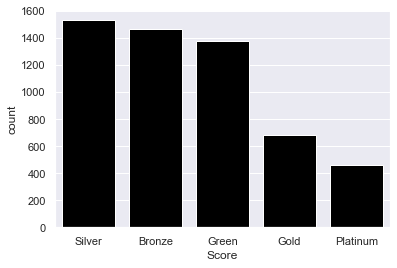

In [65]:
sns.set(style='darkgrid')
sns.countplot(data = rfm,  x = 'Score', order = rfm['Score'].value_counts().index,color = "black")

Peu de clients parmi les plus précieux et beaucoup de clients qui ont besoin d'attention et de réactivation. Mieux vaut se mettre au travail.
